# 1. Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set_theme(style="whitegrid")

import random

import xgboost as xgb

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import root_mean_squared_error, mean_absolute_percentage_error

from xgboost import plot_importance

from skopt import BayesSearchCV
from skopt.space import Real, Integer

from pathlib import Path

import joblib

## 1.1. Defining paths

In [22]:
FOLDER_PATH = Path("../data/processed")

MODEL_PATH = Path("../model")

## 1.2. Loading data

In [3]:
df_train = pd.read_csv(filepath_or_buffer=FOLDER_PATH / "train.csv", low_memory=False)
df_test = pd.read_csv(filepath_or_buffer=FOLDER_PATH / "test.csv", low_memory=False)

In [4]:
df_train["Date"] = pd.to_datetime(df_train["Date"])
df_test["Date"] = pd.to_datetime(df_test["Date"])

# 2. Machine learning model

## 2.1. Defining train and test sets

In [5]:
seed = 42

In [6]:
X_train = df_train.drop(columns=["Date", "Sales", "Customers"])
y_train = df_train[["Sales"]]

In [7]:
X_test = df_test.drop(columns=["Date", "Sales", "Customers"])
y_test = df_test[["Sales"]]

In [8]:
# Checking if both datasets have the same columns
assert len(X_train.columns) == len(X_test.columns), 'Different columns between X_train and X_test'

## 2.2. XGBoost - First approach using all columns

In [9]:
def root_mean_square_percentage_error(y_true, y_pred):
    rmspe = np.sqrt(np.mean(((y_true.values.reshape(len(y_true)) - y_pred) / y_true.values.reshape(len(y_true)))**2))
    return rmspe

def model_performance(y_true, y_pred):
    rmspe = root_mean_square_percentage_error(y_true, y_pred)
    rmse = root_mean_squared_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)

    return pd.DataFrame({'RMSPE': rmspe,
                         'RMSE': rmse,
                         'MAPE': mape},
                         index=[0])

In [10]:
reg_xgb = xgb.XGBRegressor(n_estimators = 500, enable_categorical=True, tree_method="hist", random_state=seed)
reg_xgb.fit(X=X_train, y=y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=500,
             n_jobs=None, num_parallel_tree=None, ...)

In [11]:
y_pred_xgb = reg_xgb.predict(X=X_test)

In [12]:
# Evaluating model performance
model_performance(y_true=y_test, y_pred=y_pred_xgb)

,RMSPE,RMSE,MAPE
0,0.136835,901.637451,0.093138


## 2.3. Feature importance filtering

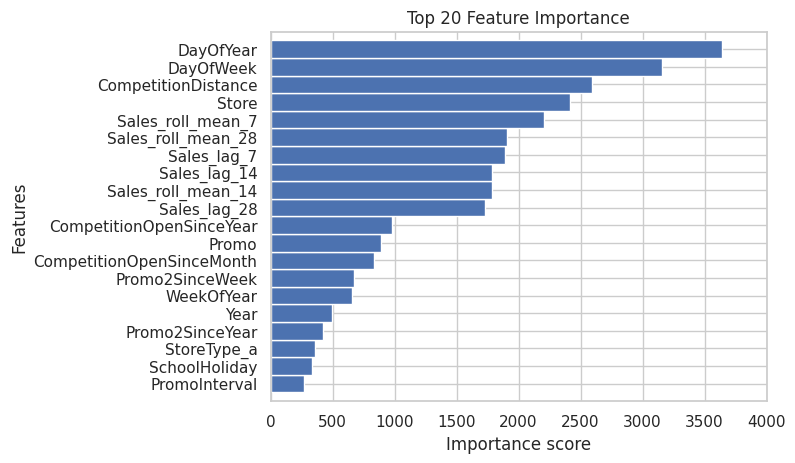

In [13]:
plot_importance(reg_xgb, importance_type="weight",
#plot_importance(reg_xgb, importance_type="gain",
                max_num_features=20,
                height=1,
                title="Top 20 Feature Importance",
                show_values=False);

In [14]:
importances = reg_xgb.get_booster().get_score(importance_type="weight")
#importances = reg_xgb.get_booster().get_score(importance_type="gain")

feature_importances = pd.DataFrame(list(importances.items()),
                                   columns=["Feature", "Importance"])\
                                  .set_index("Feature").sort_values(by="Importance", ascending=False)

In [ ]:
#best_k = 0
#best_rmspe = 1.0e6
#best_rmse = 1.0e6
#best_rmape = 1.0e6

#for k in range(1, (len(feature_importances)+1)//2):
for k in range(1, (len(feature_importances)+1)):
    topKfeat = feature_importances.iloc[:k,:].index
    reg_xgb_filtered = xgb.XGBRegressor(n_estimators = 800, enable_categorical=True, random_state=seed)
    reg_xgb_filtered.fit(X=X_train[topKfeat], y=y_train)
    y_pred_xgb_filtered = reg_xgb_filtered.predict(X=X_test[topKfeat])
    rmspe = root_mean_square_percentage_error(y_true=y_test, y_pred=y_pred_xgb_filtered)
    rmse = root_mean_squared_error(y_true=y_test,y_pred=y_pred_xgb_filtered)
    mape = mean_absolute_percentage_error(y_true=y_test, y_pred=y_pred_xgb_filtered)
    print(f"Number of features={k}: RMSPE={rmspe:.4f}, RMSE={rmse:.2f}, MAPE={mape:.4f}")
    #if rmspe < best_rmspe:
    #    best_k = k
    #    best_rmspe = rmspe
    #    best_rmse = rmse
    #    best_mape = mape

#print(f"Número de features={best_k}: RMSPE={best_rmspe}, RMSE={best_rmse}, MAPE={best_mape}") 

Number of features=1: RMSPE=0.5180, RMSE=2928.22, MAPE=0.3404
Number of features=2: RMSPE=0.4810, RMSE=2790.49, MAPE=0.3273
Number of features=3: RMSPE=0.4023, RMSE=2452.29, MAPE=0.2791
Number of features=4: RMSPE=0.1771, RMSE=1206.71, MAPE=0.1283
Number of features=5: RMSPE=0.1554, RMSE=1083.75, MAPE=0.1131
Number of features=6: RMSPE=0.1444, RMSE=1015.94, MAPE=0.1058
Number of features=7: RMSPE=0.1431, RMSE=1004.55, MAPE=0.1050
Number of features=8: RMSPE=0.1407, RMSE=994.63, MAPE=0.1033
Number of features=9: RMSPE=0.1461, RMSE=978.30, MAPE=0.1029
Number of features=10: RMSPE=0.1463, RMSE=978.45, MAPE=0.1018
Number of features=11: RMSPE=0.1554, RMSE=986.68, MAPE=0.1029
Number of features=12: RMSPE=0.1312, RMSE=908.44, MAPE=0.0943
Number of features=13: RMSPE=0.1334, RMSE=903.45, MAPE=0.0931
Number of features=14: RMSPE=0.1299, RMSE=902.04, MAPE=0.0919
Number of features=15: RMSPE=0.1334, RMSE=911.50, MAPE=0.0931
Number of features=16: RMSPE=0.1389, RMSE=997.68, MAPE=0.1017
Number of 

## 2.4. Hyperparameter tunning

In [ ]:
# Chossing top 14 features
k = 14

topKfeat = feature_importances.iloc[:k,:].index

In [134]:
reg_xgb_tun = xgb.XGBRegressor(enable_categorical=True,
                               random_state=seed)

In [ ]:
# Using TimeSeriesSplit to ensure that the validation set is always after the training set in cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Searching space
xgb_space = {
    "n_estimators": Integer(100, 5000),
    "max_depth": Integer(3,10),
    "learning_rate": Real(0.001, 0.5, prior="log-uniform"),
    "subsample": Real(0.05, 1.0, prior="uniform"),
    "colsample_bytree": Real(0.1, 1.0, prior="uniform"),
    "min_child_weight": Real(1, 10),
    "reg_alpha": Real(0.0, 1.0, prior="uniform"),
    "reg_lambda": Real(0.0, 5.0, prior="uniform"),
    "gamma": Real(0.0, 5.0, prior="uniform")
}

reg_xgb_opt = BayesSearchCV(estimator=reg_xgb_tun,
                            search_spaces=xgb_space,
                            scoring="neg_root_mean_squared_error",
                            n_iter=10,
                            cv=tscv,
                            random_state=seed,
                            n_jobs=-1)

In [137]:
reg_xgb_opt.fit(X=X_train[topKfeat], y=y_train)

BayesSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
              estimator=XGBRegressor(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=True, eval_metric=None,
                                     feature_types=None, feature_weights=None,
                                     gamma=None...
                             'min_child_weight': Real(low=1, high=10, prior='uniform', transform='normalize'),
                             'n_estimators': Integer(low=100, high=5000, prior='uniform', transform='normalize'),
                             'reg_alpha': Real(low=0.0, high=1.0, prior='uniform', transform='normalize'),
                             'reg_lambda': Real(low=0.0, high=5.0, prior='uniform', transform='normalize'),
                             'subsample': Real(low=0.05, high=1.0, prior='uniform', transform='normalize')})

In [138]:
reg_xgb_opt.best_score_*(-1)

np.float64(1157.1771728515625)

In [ ]:
best_params = reg_xgb_opt.best_params_
best_params

## 2.5. Saving model

In [ ]:
#Saving model and top k feature names
joblib.dump(value=[reg_xgb_opt, topKfeat], filename=MODEL_PATH / "xgb_model_tuned.pkl")

['../model/xgb_model_tuned.pkl']

# 3. Predictions

## 3.1. Loading model

In [23]:
model_loaded, topKfeatures_loaded = joblib.load(filename=MODEL_PATH / "xgb_model_tuned.pkl")

## 3.2. Model performance

### 3.2.1. General

In [27]:
y_pred = model_loaded.predict(X=X_test[topKfeatures_loaded])

model_performance(y_true=y_test, y_pred=y_pred)

,RMSPE,RMSE,MAPE
0,0.143219,918.461609,0.098532


### 3.2.2. Example for a random store

In [138]:
# Randomly choosing a store to make predictions
store_number = random.randint(1, X_test["Store"].nunique())

df_pred = df_test[["Store", "Date", "Sales"]].copy()
df_pred["Predicted_Sales"] = y_pred
store_sales = df_pred[df_pred["Store"] == store_number]["Predicted_Sales"]

rmspe = root_mean_square_percentage_error(y_true=df_pred[df_pred["Store"] == store_number]["Sales"], y_pred=store_sales)

print(f"The sales forecast for store {store_number} in the next six weeks is US$ {store_sales.sum():.2f}")
print(f"Local RMSPE: {rmspe:.4f}")

The sales forecast for store 342 in the next six weeks is US$ 487034.66
Local RMSPE: 0.0728


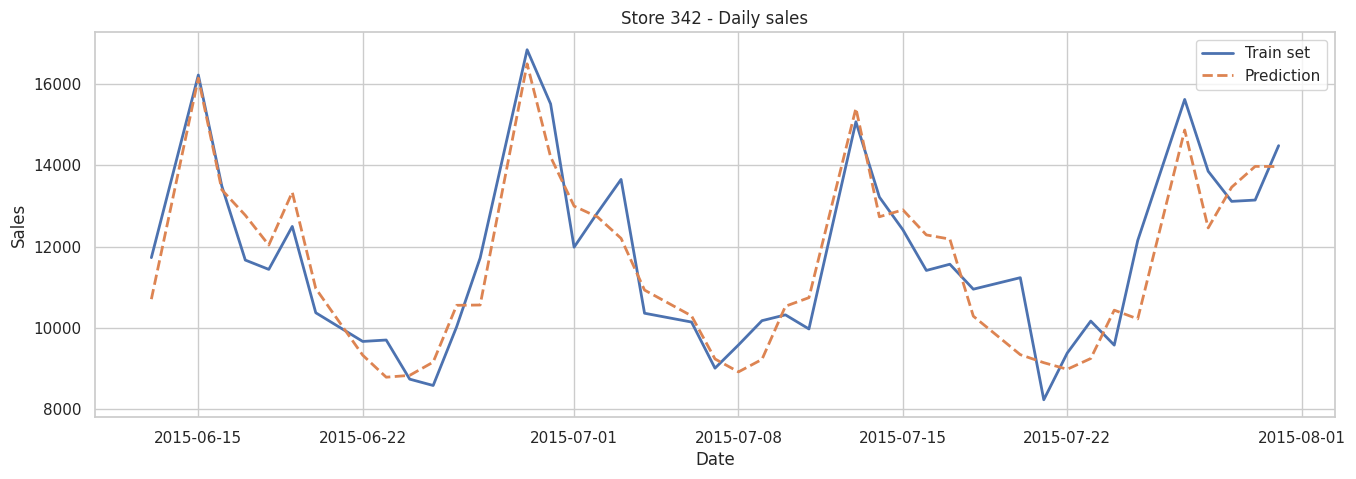

In [139]:
fig, ax = plt.subplots(figsize=(16,5))
sns.lineplot(data=df_pred[df_pred["Store"] == store_number], x="Date", y="Sales", label="Train set", lw=2)
sns.lineplot(data=df_pred[df_pred["Store"] == store_number], x="Date", y="Predicted_Sales", label="Prediction", lw=2, linestyle="--")
plt.title(f"Store {store_number} - Daily sales");